# Introduction to Classifiers in Machine Learning
## Abstract:
In this talk, machine learning perspectives on classification problems will be discussed. Model complexity, error, and regularization techniques will be described in the context of a variety of machine learning classifiers, as well as the "curse of dimensionality", and feature selection techniques

## Useful Resources:
"*The Elements of Statistical Learning* (ESL) is intended for individuals with advanced training in the mathematical sciences. *An Introduction to Statistical Learning* (ISL) arose from the perceived need for a broader and less technical treatment of these topics."

* [*The Elements of Statistical Learning*](https://web.stanford.edu/~hastie/local.ftp/Springer/OLD/ESLII_print4.pdf)    
* [*An Introduction to Statistical Learning*](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf)
* [R-Bloggers post with link to a youtube lecture series by two of the authors](http://www.r-bloggers.com/in-depth-introduction-to-machine-learning-in-15-hours-of-expert-videos/)
* kdnuggets.com

## First: Pandas

"[*pandas*](http://pandas.pydata.org/) is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language."

You can use pandas to read a variety of filetypes, including fixed-width, csv, xlsx, and many more.

In [1]:
import pandas as pd
SMMData = pd.read_excel("data/combined-SMM-data.xlsx")

## Data Exploration
We can also use pandas to perform some column selection, view a sample of our data, and generate some simple summary statistics

In [2]:
interestingVariables = ['Initiation Date','Number of Visits','Regular card replacement','Expedited card replacement','Mbr2','Discount']

print("Show the first 5 records with head")
print(SMMData[interestingVariables].head())
print()

print("Notice that we only get summary statistics of the numeric columns")
print(SMMData[interestingVariables].describe())
print()


print("We can instead generate value_counts")
print(SMMData['Mbr2'].value_counts())
print(SMMData['Initiation Date'].value_counts())
print()

Show the first 5 records with head
  Initiation Date  Number of Visits  Regular card replacement  \
0      2014-10-16                 2                         0   
1      2014-03-18                 5                         1   
2      2014-03-17                 1                         1   
3      2014-07-22                 2                         0   
4      2014-12-09                 1                         0   

   Expedited card replacement Mbr2 Discount  
0                           1    A       $5  
1                           0    A       $5  
2                           0    A       $5  
3                           1    A        0  
4                           0    B      15%  

Notice that we only get summary statistics of the numeric columns
       Number of Visits  Regular card replacement  Expedited card replacement
count       9533.000000               1191.000000                 1191.000000
mean           2.722438                  0.343409                    0.5020

Populating the interactive namespace from numpy and matplotlib


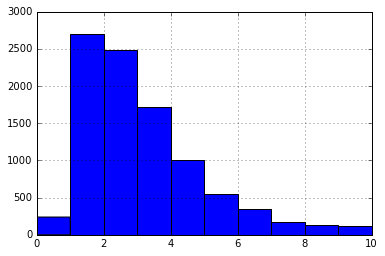

In [3]:
# We can also use pandas for histograms!
%pylab inline
SMMData['Number of Visits'].hist(bins=range(11))

# On to the good stuff!

Model complexity in regression and classification:
* In regression complexity increases from linear to polynomial (see following example from sklearn's [docs](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html) )

Automatically created module for IPython interactive environment


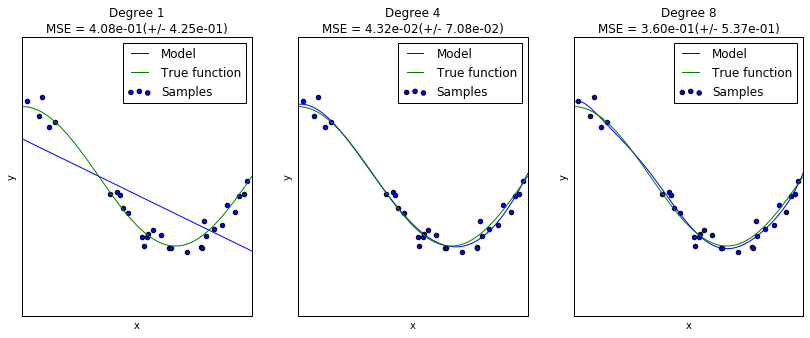

In [4]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 8]

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_validation.cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## Applications to classification problems for real this time!

One way to look at this overfitting problem is in terms of "degrees of freedom". A simple linear model looks like the familiar formula: $y=mx+b $. In model development, we know $X$ and $y$ are, but m and b are unknown. These are the two degrees of freedom for our model. These two parameters go a long way in a lot of problems but they can't represent anything more interesting than a line. Adding two more terms, to get an expression like $y=kx^3+lx^2+mx+b $, we get to the central plot above, which is obviously a much better model for the sine curve.

We might think adding more degrees of freedom will just make our model more better, but we can see from the final plot that this isn't actually true!
* Many of our samples are better
* MOST of the line between samples is FURTHER from the true sine curve!

So regression models can get squiggly when they're overfit. What does any of this have to do with classification problems?

Interpretation of parameters isn't as simple as y=mx+b anymore, but every classification method you apply will still have some concept like degrees of freedom



## Decision Trees and 20 Questions
Decision Trees are great at automatically generating large sets of rules.

* Did a Museum member visit more than 4 times?
* Did they sign up for Science Museum News? 
* Did the member receive an expedited card replacement?
* Did they ALSO receive a \$15 discount?
* (Is the member larger than a breadbox?)

Without some restriction on how we construct our decision trees, it's completely possible to accidentally play a game of 20 questions, and put each of your training points into a neat little box without learning anything about the data you haven't seen yet. 

But if data we haven't seen yet is so important, how can you figure out what you know about that data?

## Train-Test Splits and Cross-Validation
### a.k.a. intentional forgetfulness

One of the key drivers behind recent interest in machine learning is access to HUGE datasets, the development of algorithms capable of analyzing those datasets in theory, and the production of hardware that can run the algorithms on that data quickly enough that we don't fall asleep waiting.

The ability to collect and store these huge datasets makes it possible to construct a model using only SOME of the collected data. In our science museum problem, for example, we've got 9548 rows, and the renewal status of 978 of those entries is held out by the organizers. By judging teams' submissions on the 978 data points, the organizers are able to make sure that our algorithms don't simply learn complicated rules that essentially memorize who renewed and who didn't.

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


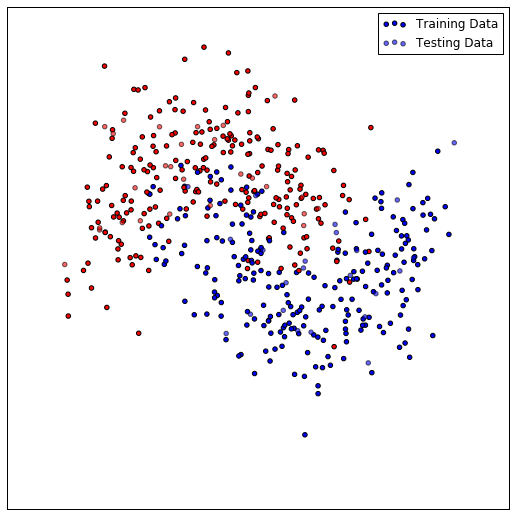

In [12]:
## A visual example of a train-test split
from sklearn.datasets import make_moons
from sklearn.cross_validation import train_test_split
from matplotlib.colors import ListedColormap
%pylab inline

X,y = make_moons(noise=0.3, random_state=0,n_samples=500)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

cm_bright = ListedColormap(['#FF0000', '#0000FF'])


plt.figure(figsize=(9,9))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,label="Training Data")
    # and testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,label="Testing Data")
plt.legend()
plt.xlim([-2,3])
plt.ylim([-2,2])
plt.xticks(())
plt.yticks(())
plt.show()

## More Benefits of Data Scale

So more data lets us ensure our models aren't behaving poorly. Are there any other benefits? Absolutely!

At the same time that data allows us to check whether or not the models we develop are getting too complex by holding some data back, more data is necessary to support more complicated **decision boundaries**


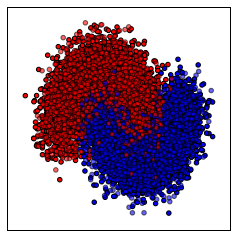

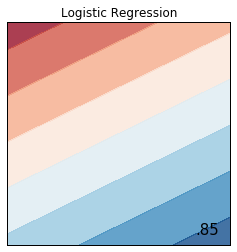

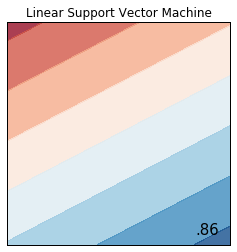

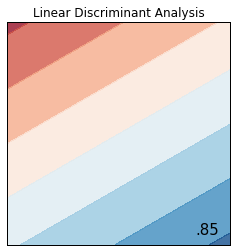

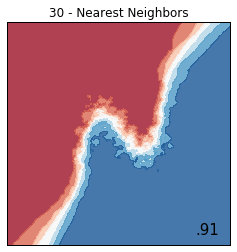

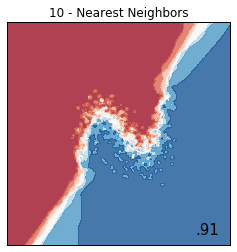

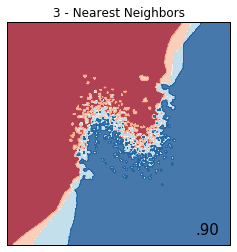

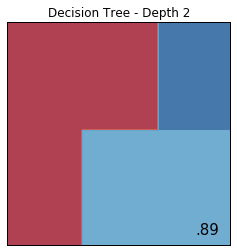

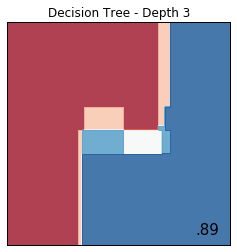

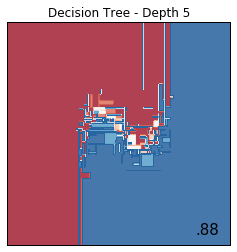

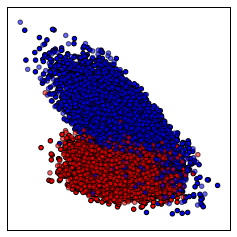

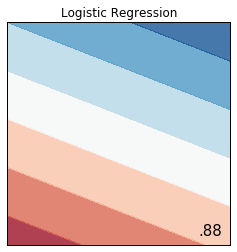

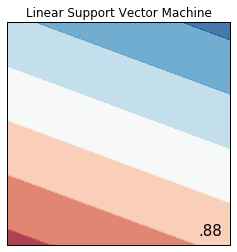

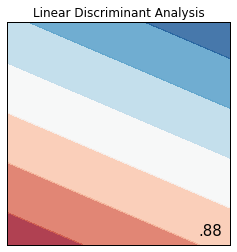

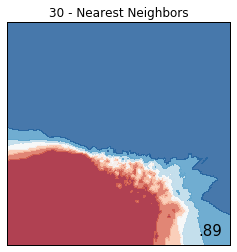

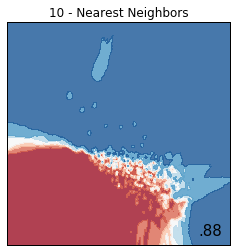

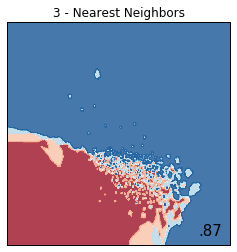

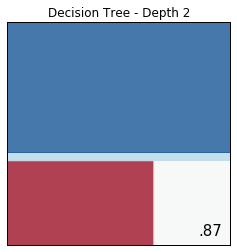

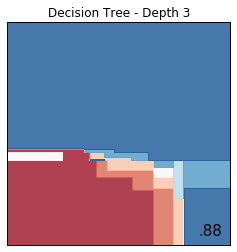

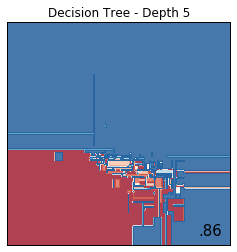

In [14]:


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = [ "Logistic Regression", "Linear Support Vector Machine", "Linear Discriminant Analysis",
         "30 - Nearest Neighbors", "10 - Nearest Neighbors", "3 - Nearest Neighbors", 
         "Decision Tree - Depth 2","Decision Tree - Depth 3", "Decision Tree - Depth 5"]

classifiers = [
    LogisticRegression(),
    SVC(kernel="linear", C=0.025),
    LinearDiscriminantAnalysis(),
    KNeighborsClassifier(30),
    KNeighborsClassifier(10),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=5),
    DecisionTreeClassifier(max_depth=15)]

n_Training_Data = 12000

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, n_samples=n_Training_Data,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0,n_samples=n_Training_Data),
            linearly_separable
            ]

i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    plt.figure(figsize=(4,4))
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    # Plot the training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        i += 1
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(figsize=(4,4))
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

#         # Plot also the training points
#         plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
#         # and testing points
#         plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
#                    alpha=0.6)

        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(name)
        plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
        plt.show()


In [7]:
from sklearn.tree import DecisionTreeClassifier
SMMData.fillna(-1,inplace=True)

Automatically created module for IPython interactive environment


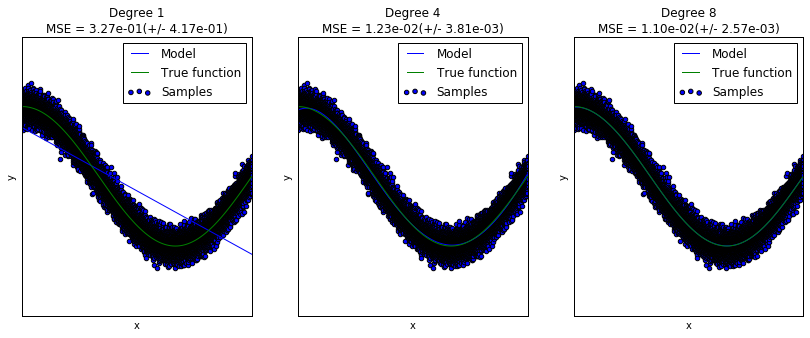

In [8]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

np.random.seed(0)

n_samples = 30000
degrees = [1, 4, 8]

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_validation.cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## Curse of Dimensionality

So more data is always better, right? WRONG!

K-Nearest Neighbors looked pretty good in both of those problems, right? So why don't K-Nearest Neighbor based models win all the kaggle competitions? When we add more features to our dataset, we run into a strange phenomenon. Imagine there's only one feature, and it takes on any value between 0 and 1. If there's a datapoint in the center, 10% of the range is with .05 of that point. In two dimensions, only 1% of the data is within .05 in those two dimensions.

This means that even points that are very similar in every way will seem far away because they're a little different in so many ways. We need some way of focusing on the IMPORTANT differences.